In [1]:
# Data Dictionary

* datetime : hourly date + timestamp

* season : 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울

* holiday : 1 = 토,일요일의 주말을 제외한 국경일과 같은 휴일, 0 = 휴일이 아닌 날

* workingday: 1 = 토,일요일의 주말과 휴일을 제외, 0 = 주말 및 휴일

* weather:


    + 1 = 맑음, 약간 구름 낀 흐림    
    + 2 = 안개, 안개 + 흐림    
    + 3 = 가벼운 눈, 가벼운 비 + 천둥    
    + 4 = 심한 눈, 심한 비+ 천둥
    
   
* temp = 온도(섭씨)

* atemp = 체감온도(섭씨)

* humidity = 습도

* windspeed = 풍속  

* casual = 사전 미등록자가 대여한 횟수

* registered = 사전 등록자가 대여한 횟수

* count = 대여횟수

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor


In [19]:
bike_df = pd.read_csv('D:/pythonTest/bike-sharing-demand/train.csv')
bike_df.shape

(10886, 12)

In [10]:
bike_df.shape

(10886, 12)

In [11]:
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [20]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [22]:
# 위에서의 object는 datetime 만이 존재
# 따라서 object -> datetime으로 변환

bike_df['datetime'] = pd.to_datetime(bike_df['datetime']) # 방법1
bike_df['datetime'] = bike_df['datetime'].apply(pd.to_datetime) # 방법2

In [25]:
bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)

In [28]:
bike_df_new = bike_df.drop(['datetime','casual','registered'], axis=1)
bike_df_new

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19
10882,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20
10883,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21
10884,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22


In [30]:
# kaggle에서 요구한 평가성능지표 :: RMSLE

from sklearn.metrics import mean_squared_error

# log 변환 시 NAN 및 inf등의 이슈가 있으므로..
# log()가 아닌 log1p()을 활용하여 사용자 정의 함수를 생성
# log1p :: log + 1

def rmsle(y_test, pred):
    log_y = np.log1p(y_test) # actual_y를 log1p를 사용하여 변환
    log_pred = np.log1p(pred) # pred_y를 log1p에 적용
    squared_error = (log_y-log_pred)**2
    rmsle_result = np.sqrt(np.mean(squared_error))
    
    return rmsle_result

In [31]:
def rmse(y_test, pred):
    result = np.sqrt(mean_squared_error(y_test, pred))
    return result

In [46]:
# 위의 지표들을 합쳐서 생성해보자

def eval_reg(y_test, pred):
    rmsle_eval = rmsle(y_test, pred)
    rmse_eval = rmse(y_test, pred)
    # mae도 넣어보자
    mae_eval = mean_absolute_error(y_test, pred)
    print('RMSLE:{0:.4f}, RMSE:{1:.4f}, MAE:{2:.4f}'.format(rmsle_eval, rmse_eval, mae_eval))
    
# 참고 : log1p를 원상복귀(원복)시키고 싶다면, expm1()함수를 통해서 손쉽게 되돌릴 수 있음

In [47]:
bike_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   year        10886 non-null  int64  
 10  month       10886 non-null  int64  
 11  day         10886 non-null  int64  
 12  hour        10886 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 1.1 MB


In [48]:
# ftr scaling 및 modeling :: fit/pred/eval

from sklearn.model_selection import train_test_split

y_target = bike_df_new['count']
X_features = bike_df_new.drop('count', axis=1)

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred_y_lr = lr_reg.predict(X_val)

eval_reg(y_val, pred_y_lr)
# 실제대여횟수와 비교해보면, 은근히 오류가 큰 편임

RMSLE:1.1647, RMSE:140.8996, MAE:105.9244


C:\Users\USER\AppData\Local\Temp/ipykernel_2540/2406309880.py:11: RuntimeWarning: invalid value encountered in log1p
  log_pred = np.log1p(pred) # pred_y를 log1p에 적용


In [58]:
check_df = pd.DataFrame(y_val.values, columns=['actual_y'])
check_df['predicted_y'] = pred_y_lr
check_df
check_df['diff'] = np.abs(check_df['actual_y']-check_df['predicted_y'])
check_df.sort_values(by='diff', ascending=False).reset_index()[:10]

,index,actual_y,predicted_y,diff
0,1618,890,322.117787,567.882213
1,966,884,326.704555,557.295445
2,3151,798,241.365876,556.634124
3,412,745,193.895003,551.104997
4,2277,813,266.977808,546.022192
5,2817,856,310.080940,545.919060
6,454,721,176.740660,544.259340
7,2314,766,222.362124,543.637876
8,1003,713,170.723496,542.276504
9,2394,684,142.451960,541.548040


<AxesSubplot:>

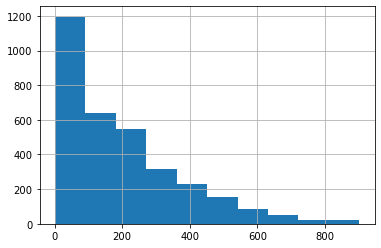

In [59]:
y_val.hist()

<AxesSubplot:>

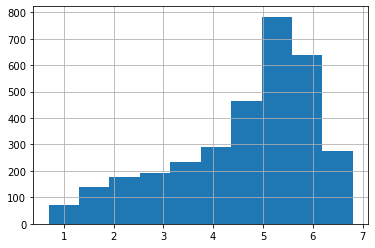

In [62]:
log_y_val = np.log1p(y_val)

log_y_val.hist()

In [67]:
# target
y_target_log = np.log1p(y_target)
y_target_log

# 로그 변환된 y_target_log를 반영해서
# train_test_splirt

X_train, X_test, y_train_log, y_test_log = train_test_split(X_features, y_target_log,
                                                           test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train_log) # y가 log로 변환된 값이 입력되었음
pred_log = lr_reg.predict(X_test) # pred 결과값 또한 log로 나올 것임

# 테스트 데이터 셋의 Target은 로그변환되었으므로
# 다시 expm1(원복함수)을 활용해서 원래의 y로 변환시킨다
y_test_exp = np.expm1(y_test_log)

# 예측값(pred_log) 또한 로그 변환된 타깃 기반이었으므로
# 다시 expm1을 활용해서 원래의 pred로 변환시킨다
pred_exp = np.expm1(pred_log)


eval_reg(y_test_exp, pred_exp)

RMSLE:1.0168, RMSE:162.5943, MAE:109.2862


<AxesSubplot:>

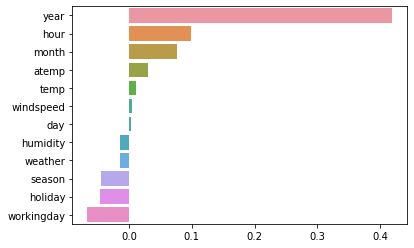

In [71]:
# RMSLE는 줄어들었으나,
# RMSE는 오히려 늘어났음
# 이유를 규명하기 위해서 시각화 진행

coeff_sort = pd.Series(lr_reg.coef_, index=X_features.columns).sort_values(ascending=False)
sns.barplot(x=coeff_sort, y=coeff_sort.index)

In [72]:
bike_df_new.year.value_counts()

2012    5464
2011    5422
Name: year, dtype: int64

In [75]:
# year는 연도를 뜻하므로 카테고리형 피쳐이지만
# 숫자의 값으로 되어 있음
# 더군다나 2011 및 2012로만 되어 있음

# 따라서 위의 데이터들을 원-핫 인코딩을 진행하여 살펴볼 필요가 있음

X_ftrs_oh = pd.get_dummies(X_features, columns=['year','month','hour','holiday',
                                                'workingday','season','weather'])
X_ftrs_oh

,temp,atemp,humidity,windspeed,day,year_2011,year_2012,month_1,month_2,month_3,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,19,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10882,14.76,17.425,57,15.0013,19,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10883,13.94,15.910,61,15.0013,19,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10884,13.94,17.425,61,6.0032,19,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0


In [76]:
# LinearRegression,
# Ridge(L2규제)
# Lasso(L1규제)
# 선형기반의 회귀분석을 진행하자

X_train_oh, X_test_oh, y_train_log, y_test_log = train_test_split(X_ftrs_of, y_target_log,
                                                                 test_size=0.3, random_state=0)
# 위의 데이터의 분할의 X는 원핫인코딩이 진행된 녀석
# 위의 데이터 분할의 y는 log_scaled가 된 데이터

In [80]:
# 알고리즘 적용하기
# 선형회귀식 기반의 회귀알고리즘 호출

from sklearn.linear_model import Ridge, Lasso

lr_reg = LinearRegression()
ridge = Ridge(alpha=10) # L2규제 - alpha값의 영향을 L1보다 덜받는다
lasso = Lasso(alpha=0.01) # L1규제 - alpha값에 영향을 받아 불필요변수 0으로..

for model in [lr_reg,ridge,lasso]:
    model.fit(X_train_oh,y_train_log)
    pred = model.predict(X_test_oh) # log 결과값을 호출할 계획
    y_test_expm1 = np.expm1(y_test_log) # 실제 y값을 원복
    pred_expm1 = np.expm1(pred) # pred(예측 y값)을 원복    
    print('\n ###', model.__class__.__name__, '### \n')
    eval_reg(y_test_expm1,pred_expm1)


 ### LinearRegression ### 

RMSLE:0.5889, RMSE:97.4842, MAE:63.1059

 ### Ridge ### 

RMSLE:0.5895, RMSE:98.4069, MAE:63.6483

 ### Lasso ### 

RMSLE:0.6344, RMSE:113.0309, MAE:72.6582


<AxesSubplot:>

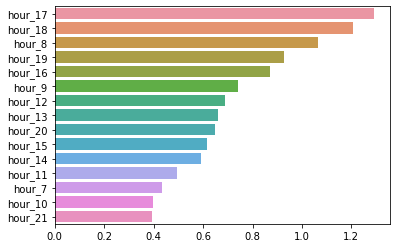

In [81]:
# one_hot_encoding 시각화
# ridge
coef = pd.Series(ridge.coef_, index=X_ftrs_oh.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

# one_hot_encoding 시각화
# lasso
coef = pd.Series(ridge.coef_, index=X_ftrs_oh.columns)
coef_sort = coef.sort_values(ascending=False)[:15]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [85]:
# CART의 Regressor 적용
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

X_train_oh, X_test_oh, y_train_log, y_test_log # 데이터를 확인해보자

# 각 트리 모델별로 학습수행
rf_reg = RandomForestRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)
dt_reg = DecisionTreeRegressor()

for model in [rf_reg,lgbm_reg,dt_reg]:
    model.fit(X_train_oh,y_train_log)
    pred = model.predict(X_test_oh) # log 결과값을 호출할 계획
    y_test_expm1 = np.expm1(y_test_log) # 실제 y값을 원복
    pred_expm1 = np.expm1(pred) # pred(예측 y값)을 원복    
    print('\n ###', model.__class__.__name__, '### \n')
    eval_reg(y_test_expm1,pred_expm1)


 ### RandomForestRegressor ### 

RMSLE:0.3543, RMSE:50.6502, MAE:31.4630

 ### LGBMRegressor ### 

RMSLE:0.3158, RMSE:46.4733, MAE:28.7773

 ### DecisionTreeRegressor ### 

RMSLE:0.4821, RMSE:69.3914, MAE:42.1099
